# Introduction

This notebook projects the vehicle count by county in NYS using two data sources:

1. Current vehicle registration data by county (from DMV)
2. Future vehicle count projection in NYS (from NYSERDA Climate Act Scoping Plan)

It assumes that the distribution of vehicle counts by county in NYS will remain the same in the future.

The output of this notebook is a CSV file with the projected vehicle count by county in NYS.

# Packages

In [120]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [108]:
# Set up path directory
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'NYSERDA_Data')
output_dir = os.path.join(cwd, 'InputData')
print(f'Data directory: {data_dir}')
print(f'Output directory: {output_dir}')

Data directory: e:\EERL2\EV\EVI-Pro-Lite\NYSERDA_Data
Output directory: e:\EERL2\EV\EVI-Pro-Lite\InputData


# Current vehicle count

In [109]:
# Read NYS zip code data
zipcode_df = pd.read_csv(os.path.join(data_dir, 'nys_zipcode.csv'))
zipcode_df = zipcode_df[['ZIP Code', 'County']]


In [110]:
# Read current vehicle registration data
vehicle_df = pd.read_csv(os.path.join(data_dir, 'Current Registrations.csv'))

# Drop rows with missing ZIP Code
vehicle_df = vehicle_df[vehicle_df['ZIP Code'] != 'Error']

# Filter for NYS zip codes
vehicle_df['ZIP Code'] = vehicle_df['ZIP Code'].astype(int)
vehicle_df = vehicle_df[vehicle_df['ZIP Code'].isin(zipcode_df['ZIP Code'])]


In [111]:
# Group by zip code and sum vehicle count
vehicle_by_zip = vehicle_df.groupby('ZIP Code')['Vehicle Count'].sum().reset_index()

# Group by county and sum vehicle count
vehicle_by_county = vehicle_by_zip.merge(zipcode_df, on='ZIP Code', how='left')
vehicle_by_county = vehicle_by_county.groupby('County')['Vehicle Count'].sum().reset_index()

# Percentage of vehicles by county
vehicle_by_county['Percentage'] = vehicle_by_county['Vehicle Count'] / vehicle_by_county['Vehicle Count'].sum()
vehicle_by_county

,County,Vehicle Count,Percentage
0,Albany County,236214,0.021072
1,Allegany County,36836,0.003286
2,Bronx County,295553,0.026366
3,Broome County,147283,0.013139
4,Cattaraugus County,60274,0.005377
...,...,...,...
58,Washington County,58142,0.005187
59,Wayne County,87527,0.007808
60,Westchester County,684472,0.061061
61,Wyoming County,35948,0.003207


In [112]:
total_vehicles = vehicle_by_zip['Vehicle Count'].sum()
print(f'Total number of vehicles in NYS: {total_vehicles:.2e}')

Total number of vehicles in NYS: 1.12e+07


# Future vehicle count

In [113]:
# Read NYS total vehicle count projection
# Data source: NYSERDA Climate Act Scoping Plan
# Light duty vehicle (LDV) stock forecast
ldv_proj_df_all_scen = pd.read_csv(os.path.join(data_dir, 'LDV_stock_forecast.csv'))
display(ldv_proj_df_all_scen['Scenario'].unique())
display(ldv_proj_df_all_scen['Vehicle Type'].unique())

scenarios_list = ldv_proj_df_all_scen['Scenario'].unique().tolist()

scenario = "AP Recommendations"

# Column names of years from 2020 to 2050
year_cols = ldv_proj_df_all_scen.columns[2:].tolist()

array(['Reference', 'AP Recommendations',
       'Strategic Use of Low-Carbon Fuels',
       'Accelerated Transition Away from Combustion',
       'Beyond 85% Reductions'], dtype=object)

array(['Battery Electric', 'CNG', 'Diesel', 'Gasoline',
       'Hydrogen Fuel Cell', 'Plug in Hybrid Electric', 'Total'],
      dtype=object)

In [114]:
# Medium and heavy duty vehicle (MHDV) stock forecast
# NOTE:MHDV is not used in the current analysis
mhdv_proj_df_all_scen = pd.read_csv(os.path.join(data_dir, 'MHDV_stock_forecast.csv'))


In [115]:
vehicle_by_county_proj_scenario = dict()

for scenario in scenarios_list:

    print(f'Processing scenario: {scenario}')

    # Light duty vehicle (LDV) stock forecast   
    ldv_proj_df = ldv_proj_df_all_scen[ldv_proj_df_all_scen['Scenario'] == scenario]
    # The unit is million vehicles
    ldv_proj_df.loc[:, year_cols] = ldv_proj_df.loc[:, year_cols] * 1e6

    # Medium and heavy duty vehicle (MHDV) stock forecast
    mhdv_proj_df = mhdv_proj_df_all_scen[mhdv_proj_df_all_scen['Scenario'] == scenario]
    # The unit is thousand vehicles
    mhdv_proj_df[year_cols] = mhdv_proj_df[year_cols] * 1e3

    # Distribute the future total vehicle count to counties
    # based on the current percentage of vehicles in each county
    # NOTE: Only consider LDV for now
    proj_total_count = ldv_proj_df[ldv_proj_df['Vehicle Type'] == 'Total'][year_cols].reset_index(drop=True)
    proj_bev_count = ldv_proj_df[ldv_proj_df['Vehicle Type'] == 'Battery Electric'][year_cols].reset_index(drop=True)
    proj_phev_count = ldv_proj_df[ldv_proj_df['Vehicle Type'] == 'Plug in Hybrid Electric'][year_cols].reset_index(drop=True)
    proj_allev_count = proj_bev_count + proj_phev_count

    # Create dataframe for future vehicle count by county
    vehicle_by_county_proj = pd.DataFrame()

    for year in year_cols:
        vehicle_by_county_proj[year] = vehicle_by_county['Percentage'] * proj_allev_count[year].to_numpy()
        vehicle_by_county_proj[year] = vehicle_by_county_proj[year].astype(int)

    vehicle_by_county_proj['County'] = vehicle_by_county['County']
    vehicle_by_county_proj = vehicle_by_county_proj.set_index('County')

    vehicle_by_county_proj_scenario[scenario] = vehicle_by_county_proj
    

Processing scenario: Reference
Processing scenario: AP Recommendations
Processing scenario: Strategic Use of Low-Carbon Fuels
Processing scenario: Accelerated Transition Away from Combustion
Processing scenario: Beyond 85% Reductions


e:\anaconda3\envs\ev\lib\site-packages\pandas\core\indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
e:\anaconda3\envs\ev\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


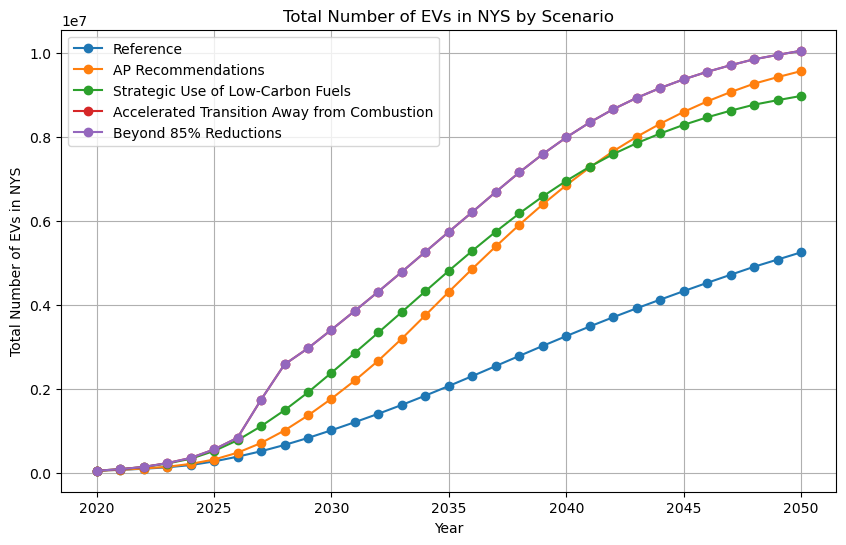

In [123]:
plt.subplots(figsize=(10, 6))

for scenario in scenarios_list:

    vehicle_by_county_proj = vehicle_by_county_proj_scenario[scenario]
    vehicle_by_county_proj.sum(axis=0).plot(kind='line', marker='o', label=scenario)

plt.xlabel('Year')
plt.ylabel('Total Number of EVs in NYS')
plt.title('Total Number of EVs in NYS by Scenario')
plt.legend()
plt.grid()


In [125]:
for scenario in scenarios_list:
    vehicle_by_county_proj = vehicle_by_county_proj_scenario[scenario]
    scenario = scenario.replace(' ', '_')
    vehicle_by_county_proj.to_csv(os.path.join(output_dir, f'EV_count_by_county_{scenario}.csv'))